# NGCF Model Implementation and Experimentation

## Introduction

Welcome to this Jupyter notebook where we explore the Neural Graph Collaborative Filtering (NGCF) model.
In this notebook, we will configure our environment, load the necessary data using a custom `DataHandler`,
and execute the NGCF model to recommend items based on user-item interactions.

Please refer to the original paper [Neural Graph Collaborative Filtering](https://arxiv.org/abs/1905.08108) by Xiang Wang et al. (2019) for detailed conceptual information.


## Environment Setup

In this section, we set up our Python environment, check for GPU availability, and import necessary modules.

### Import Statements


In [2]:
from models.ngcf import NGCFModel
import tensorflow as tf
import os
import json
import datetime
from utils.datahandler import DataHandler

### GPU Configuration Check


In [3]:
gpu_devices = tf.config.list_physical_devices("GPU")
if gpu_devices:
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print("GPU being used:")
    print(details.get("device_name", "Unknown GPU"))

GPU being used:
NVIDIA GeForce RTX 3060 Laptop GPU


## Data Preprocessing

Here, we will prepare our dataset for training and testing. We use the MovieLens dataset, preprocessed into a suitable format.


In [4]:
data_path = os.path.join("..", "datasets", "preprocessed", "movielens")
datahandler_train = DataHandler(
    dataset_path=os.path.join(data_path, "movielens_100k_train.csv"), batch_size=8192
)
datahandler_test = DataHandler(
    dataset_path=os.path.join(data_path, "movielens_100k_test.csv"), batch_size=8192
)
train_ds, test_ds = datahandler_train.load_data(), datahandler_test.load_data()
with open(os.path.join(data_path, "movielens_100k_metadata.json"), "r") as file:
    metadata = json.load(file)

In [5]:
train_ds_repeat = train_ds.repeat()
test_ds_cache = test_ds.cache()

## Model Initialization, Compilation, and Training

Here, we initialize the NGCFModel with the dataset's metadata. The number of users, items, layers, and embedding size are specified, along with the number of folds for the adjacency matrix and the directory where the adjacency matrices are saved. Following initialization, the model is compiled with the Adam optimizer and mean squared error loss function, and we track the root mean squared error as a metric.

This cell runs the training process for the NGCFModel. We use the `model.fit()` method, passing in the repeated training dataset and the cached test dataset for validation. The model is trained for 30 epochs, and verbose output is enabled to monitor progress directly within this notebook. The output shows the loss and root mean squared error after each epoch for both the training and validation datasets, providing insight into the model's learning process.


In [6]:
# Code to initialize the NGCFModel with parameters from the metadata
model = NGCFModel(
    num_users=metadata["num_users"],
    num_items=metadata["num_items"],
    num_layers=2,
    embedding_size=128,
    n_fold=1,
    adj_save_dir=os.path.join(data_path, "movielens_100k_adj_mat"),
)



# Code to compile the NGCFModel


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="mean_squared_error",
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)



log_dir = os.path.join(
    "..", "logs", "model_ngcf", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)



early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=50, verbose=1
)



# Code to fit the model to the training data


history = model.fit(
    train_ds_repeat,

    epochs=30,
    steps_per_epoch=datahandler_train.steps_per_epoch,

    validation_data=test_ds_cache,
    validation_steps=datahandler_test.steps_per_epoch,
    callbacks=[tensorboard_callback, early_stopping],
    verbose=1,
)

Epoch 1/30
11/11 [==============================] - 6s 155ms/step - loss: 9.5278 - root_mean_squared_error: 3.0867 - val_loss: 4.0599 - val_root_mean_squared_error: 2.0149
Epoch 2/30
11/11 [==============================] - 2s 121ms/step - loss: 3.5639 - root_mean_squared_error: 1.8878 - val_loss: 3.2286 - val_root_mean_squared_error: 1.7968
Epoch 3/30
11/11 [==============================] - 2s 74ms/step - loss: 2.5264 - root_mean_squared_error: 1.5895 - val_loss: 2.3129 - val_root_mean_squared_error: 1.5208
Epoch 4/30
11/11 [==============================] - 1s 59ms/step - loss: 2.1215 - root_mean_squared_error: 1.4565 - val_loss: 2.1795 - val_root_mean_squared_error: 1.4763
Epoch 5/30
11/11 [==============================] - 2s 87ms/step - loss: 1.9077 - root_mean_squared_error: 1.3812 - val_loss: 1.9453 - val_root_mean_squared_error: 1.3948
Epoch 6/30
11/11 [==============================] - 2s 62ms/step - loss: 1.7499 - root_mean_squared_error: 1.3228 - val_loss: 1.8333 - val_root

### Model Summary

The output of `model.summary()` provides a detailed overview of our NGCFModel's architecture. It lists each layer, including the type of the layer, the output shape, and the number of parameters it has. This summary is crucial for understanding the complexity of the model and ensuring that the architecture is as expected.

As we can see, the model has separate embedding layers for users and items, indicating that it learns distinct representations for both entities. Additionally, there are multiple NGCF layers, each presumably responsible for capturing different levels of interactions in the user-item graph. The total number of parameters in the model amounts to over 1 million, all of which are trainable. This gives us an insight into the scale of the model and the computational resources that might be required for training.


In [7]:
model.summary()

Model: "ngcf_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embeddings (Embedding)  multiple                 120704    
                                                                 
 item_embeddings (Embedding)  multiple                 212992    
                                                                 
 ngcf_layer (NGCFLayer)      multiple                  32768     
                                                                 
 ngcf_layer_1 (NGCFLayer)    multiple                  32768     
                                                                 
Total params: 399,232
Trainable params: 399,232
Non-trainable params: 0
_________________________________________________________________


### Visualization of Training Progress

Visualizing the training progress is crucial to understand how well our model is learning and generalizing. In the following code cell, we define a function `plot_loss_curves` which takes the training history object as input and generates two plots: one for the loss and one for the RMSE over each epoch of training. These plots are displayed side by side for easy comparison between training and validation metrics.


In [8]:
import matplotlib.pyplot as plt


def plot_loss_curves(history):
    """
    Return separate loss curves for training and validation metrics, displayed side by side.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["root_mean_squared_error"]
    val_accuracy = history.history["val_root_mean_squared_error"]

    epochs = range(len(history.history["loss"]))  # how many epochs did we run for?

    # Create a figure and a set of subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot loss on the first subplot
    ax1.plot(epochs, loss, label="training_loss")
    ax1.plot(epochs, val_loss, label="val_loss")
    # ax1.set_yscale('log')
    ax1.set_title("Loss")
    ax1.set_xlabel("epochs")
    ax1.legend()

    # Plot accuracy on the second subplot
    ax2.plot(epochs, accuracy, label="training_rmse")
    ax2.plot(epochs, val_accuracy, label="val_rmse")
    # ax2.set_yscale('log')
    ax2.set_title("RMSE")
    ax2.set_xlabel("epochs")
    ax2.legend()

    plt.tight_layout()  # Adjust the layout
    plt.show()

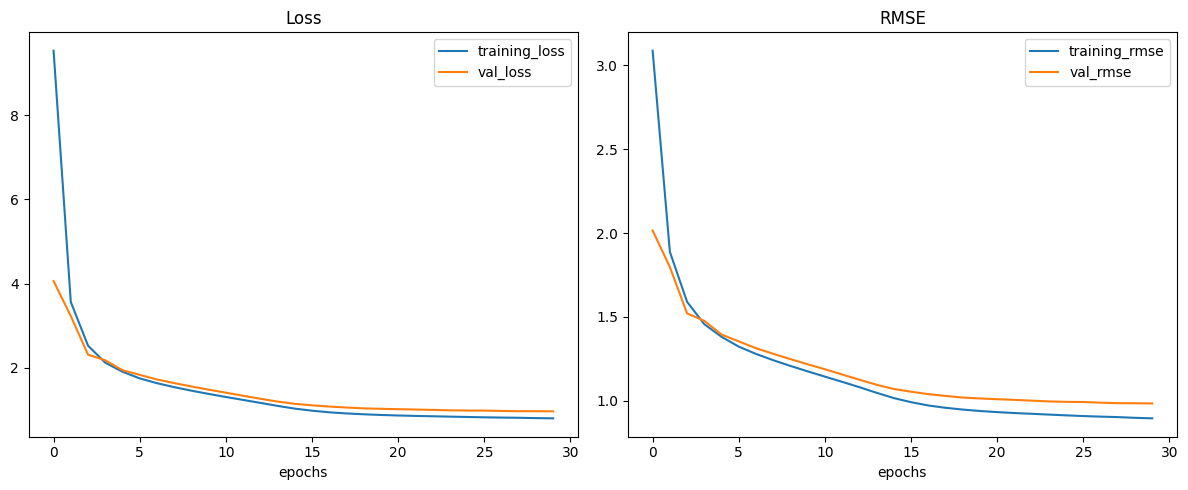

In [9]:
plot_loss_curves(history)

## Deeper Interpretation of the Training Graphs

### Loss Plot Interpretation

- **Rapid Decrease in Initial Epochs:**
  Both the training and validation loss show a steep decrease at the beginning of training, indicating that the model is learning effectively from an initial state of random weights.

- **Convergence Trend:**
  As training progresses, the decline in loss for both training and validation datasets slows down and the curves begin to plateau, which suggests the model is approaching convergence.

- **Overfitting Indicator:**
  The persistent gap between the training and validation loss suggests a mild overfitting, where the model performs slightly better on the training data compared to the unseen validation data. However, the stability of the validation loss indicates that overfitting is not severe.

### RMSE Plot Interpretation

- **Sharp Initial Improvement:**
  Similar to the loss graph, we see a sharp initial improvement in RMSE for both training and validation, indicating that the model's predictions are rapidly aligning with the actual ratings.

- **Signs of Overfitting:**
  The RMSE for training and validation decreases and converges initially, but later the validation RMSE shows a slight increase, which might be indicative of the model starting to overfit to the training data.

- **Stabilization Phase:**
  Both the training and validation RMSE stabilize towards the end of the epochs, suggesting that the model might have reached its learning capacity given the current architecture and hyperparameters.

### Overall Insights

The training dynamics demonstrated by the decreasing loss and RMSE are indicative of effective learning. The small but noticeable gap between the training and validation metrics suggests a balance between bias and variance, with some room for improvement, possibly by regularization or hyperparameter tuning. The stabilization of the metrics towards the end of training suggests diminishing returns on further training without modifications to the model or training regimen.
